## **Selecting data for ML Use Case 1**

In this notebook, we're delving into the RDD2022 dataset, specifically honing in on annotated images from Japan. Our mission is clear: to process annotation files, visualize annotations on images, and prep the data for further analysis, all with the aim of curating a dataset subset tailored for ML Use Case 1. Our focus? The detection of potholes (label code: D40). Through meticulous exploration, analysis, and evaluation, we're striving to handpick a dataset subset that not only meets but exceeds the requirements of ML Use Case 1, fueling the development of cutting-edge machine learning models for pothole detection.

In [1]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pip install tensorflow-hub

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# Import necessary libraries
import numpy as np
import sys
import tarfile
import tensorflow as tf
import tensorflow_hub as hub
from PIL import Image, ImageColor, ImageDraw, ImageFont, ImageOps
import zipfile

from collections import defaultdict
from io import StringIO
from PIL import Image

import glob
import os, subprocess, re
import shutil
import json
import pandas as pd
import xml.etree.ElementTree as ET
import cv2
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

### **1. Set Up Data Paths and Load Data:**


In [4]:
# 1. Set up paths and load data
data_root_dir = "../RDD2022/RDD2022_all_countries/"
nationality = "Japan"
mode = "Train"

In [5]:
image_destination_path = os.path.join(data_root_dir, nationality, nationality, mode, "images")
annot_destination_path = os.path.join(data_root_dir, nationality, nationality, mode, "annotations/xmls") 

# Ensure paths exist
assert os.path.exists(image_destination_path), print("Image path not found")
assert os.path.exists(annot_destination_path), print("Annotation path not found")

In [6]:
# Get list of image and annotation files
image_list = glob.glob(image_destination_path+"/*.jpg")
annot_list = glob.glob(annot_destination_path+"/*.xml")

### **2. Define Label Mapping:**

In [7]:
# 2. Define label map
label_map = {
    "D00": "Wheel mark part",
    "D01": "Construction joint part",
    "D10": "Equal interval",
    "D11": "Construction joint part",
    "D20": "Partial pavement",
    "D40": "Rutting, bump, pothole, separation",
    "D43": "Crosswalk blur",
    "D44": "White line blur"
}

### **3. Read, Parse and Visualize Annotations::**

In [8]:
# 3. Define functions for reading and parsing XML, and drawing bounding boxes
def read_and_parse_xml(xml_file_path):
    """Reads and parses an XML file."""
    tree = ET.parse(xml_file_path)
    root = tree.getroot()
    return root

# Function to draw bounding boxes on the image
def draw_bounding_boxes(image_path, annotations):
    """Draws bounding boxes on the image."""
    image = cv2.imread(image_path)

    # Check if the image was loaded successfully
    if image is None:
        print(f"Error loading image {image_path}")
        return

    for obj in annotations.findall('object'):
        name = obj.find('name').text
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)

        # Draw the bounding box on the image
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
        cv2.putText(image, name, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    # Convert BGR to RGB for displaying with matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image with bounding boxes
    plt.figure(figsize=(10, 10))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

In [9]:
# Path to the XML file
xml_file_path = annot_list[2]

# Path to the image file
image_file_path = image_list[2]

print(xml_file_path)
print(image_file_path)

# Read and parse the XML file
annotations = read_and_parse_xml(xml_file_path)

../RDD2022/RDD2022_all_countries/Japan\Japan\Train\annotations/xmls\Japan_000002.xml
../RDD2022/RDD2022_all_countries/Japan\Japan\Train\images\Japan_000002.jpg


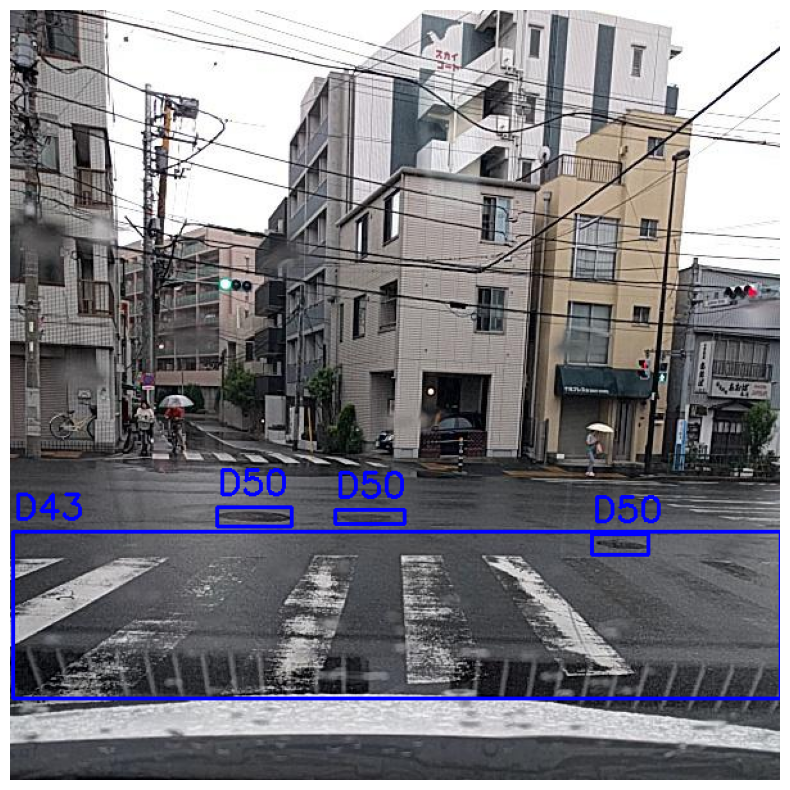

In [10]:
# Draw bounding boxes on the image
draw_bounding_boxes(image_file_path, annotations)

### **4. Process Annotations in Parallel:**

In [11]:
# 4. Functions for filtering annotations and parallel processing

def encoded_obj_annotations(annotations):
    """Encodes object annotations."""
    objects_names = []
    for obj in annotations.findall('object'):
        label_code = obj.find('name').text
        objects_names.append(label_code)
    return objects_names

def process_annotation_file(xml_file_path):
    """Processes a single annotation file."""
    annotations = read_and_parse_xml(xml_file_path)
    objects_names = encoded_obj_annotations(annotations)
    return xml_file_path, objects_names

# Function to process all annotation files in parallel and show progress
def process_all_annotations(xml_files):
    """Processes all annotation files in parallel and shows progress."""
    results = []
    with ThreadPoolExecutor() as executor:
        future_to_xml = {executor.submit(process_annotation_file, xml_file): xml_file for xml_file in xml_files}
        for future in tqdm(as_completed(future_to_xml), total=len(future_to_xml), desc="Processing files"):
            xml_file = future_to_xml[future]
            try:
                xml_file_path, objects_names = future.result()
                results.append((xml_file_path, objects_names))
            except Exception as exc:
                print(f"{xml_file} generated an exception: {exc}")
    return results

In [12]:
annotations = read_and_parse_xml(annot_list[0])
encoded_obj_annotations(annotations)

['D20', 'D40', 'D10', 'D00']

In [13]:
# Process all annotations
results = process_all_annotations(annot_list)

Processing files:  13%|█▎        | 1362/10506 [00:02<00:18, 503.29it/s]

Processing files: 100%|██████████| 10506/10506 [00:22<00:00, 471.14it/s]


### **6. Create a DataFrame with Encoded Categories:**

In [14]:
# df = pd.DataFrame(results, columns=['xml_file_path', 'objects'])

# Convert the data to a DataFrame
df = pd.DataFrame(results, columns=['xml_file_path', 'objects'])

# Create columns for each label with binary encoding
for label in label_map.keys():
    df[label] = df['objects'].apply(lambda x: x.count(label))

In [15]:
df

,xml_file_path,objects,D00,D01,D10,D11,D20,D40,D43,D44
0,../RDD2022/RDD2022_all_countries/Japan\Japan\T...,"[D20, D44, D50]",0,0,0,0,1,0,0,1
1,../RDD2022/RDD2022_all_countries/Japan\Japan\T...,"[D44, D44, D44, D10, D10]",0,0,2,0,0,0,0,3
2,../RDD2022/RDD2022_all_countries/Japan\Japan\T...,"[D50, D50]",0,0,0,0,0,0,0,0
3,../RDD2022/RDD2022_all_countries/Japan\Japan\T...,"[D44, D00, D00]",2,0,0,0,0,0,0,1
4,../RDD2022/RDD2022_all_countries/Japan\Japan\T...,[],0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
10501,../RDD2022/RDD2022_all_countries/Japan\Japan\T...,[D10],0,0,1,0,0,0,0,0
10502,../RDD2022/RDD2022_all_countries/Japan\Japan\T...,"[D10, D10]",0,0,2,0,0,0,0,0
10503,../RDD2022/RDD2022_all_countries/Japan\Japan\T...,[D00],1,0,0,0,0,0,0,0
10504,../RDD2022/RDD2022_all_countries/Japan\Japan\T...,[D20],0,0,0,0,1,0,0,0


### **7. Selecting D40 samples**

In [16]:
include_labels = {"D40"}

In [17]:
df[df["objects"].apply(lambda x: True if include_labels.intersection(set(x)) else False)]

,xml_file_path,objects,D00,D01,D10,D11,D20,D40,D43,D44
6,../RDD2022/RDD2022_all_countries/Japan\Japan\T...,"[D40, D50, D20]",0,0,0,0,1,1,0,0
16,../RDD2022/RDD2022_all_countries/Japan\Japan\T...,"[D44, D40]",0,0,0,0,0,1,0,1
20,../RDD2022/RDD2022_all_countries/Japan\Japan\T...,"[D40, D50, D20, D20]",0,0,0,0,2,1,0,0
24,../RDD2022/RDD2022_all_countries/Japan\Japan\T...,"[D20, D40, D10, D00]",1,0,1,0,1,1,0,0
30,../RDD2022/RDD2022_all_countries/Japan\Japan\T...,[D40],0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
10481,../RDD2022/RDD2022_all_countries/Japan\Japan\T...,"[D20, D40]",0,0,0,0,1,1,0,0
10482,../RDD2022/RDD2022_all_countries/Japan\Japan\T...,"[D40, D40, D40, D40, D44]",0,0,0,0,0,4,0,1
10490,../RDD2022/RDD2022_all_countries/Japan\Japan\T...,"[D20, D40, D20, D20]",0,0,0,0,3,1,0,0
10495,../RDD2022/RDD2022_all_countries/Japan\Japan\T...,"[D40, D40, D40]",0,0,0,0,0,3,0,0


### **8. Apply SSD Mobilenet module for sample images**

check the versions

In [18]:
print(tf.__version__)
print(hub.__version__)

2.16.1
0.16.1


download the models

In [32]:
ssd_url = "https://kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow1/variations/openimages-v4-ssd-mobilenet-v2/versions/1"

In [20]:
ssd_model = hub.load(ssd_url)
ssd_detector = ssd_model.signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [21]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)

In [30]:
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getbbox(ds)[3] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    bbox = font.getbbox(display_str)
    text_width, text_height = bbox[2], bbox[3]
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin

In [22]:
def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

In [23]:
def load_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels = 3)
    return img

In [24]:
def run_detector(detector, path):
    img = load_img(path)
    converted_img = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
    result = detector(converted_img)

    result = {key:value.numpy() for key, value in result.items()}
    print("Found %d objects." % len(result["detection_scores"]))

    image_with_boxes = draw_boxes(
        img.numpy(), result["detection_boxes"], result["detection_class_entities"], result["detection_scores"])
    display_image(image_with_boxes)

Found 100 objects.
Font not found, using default font.


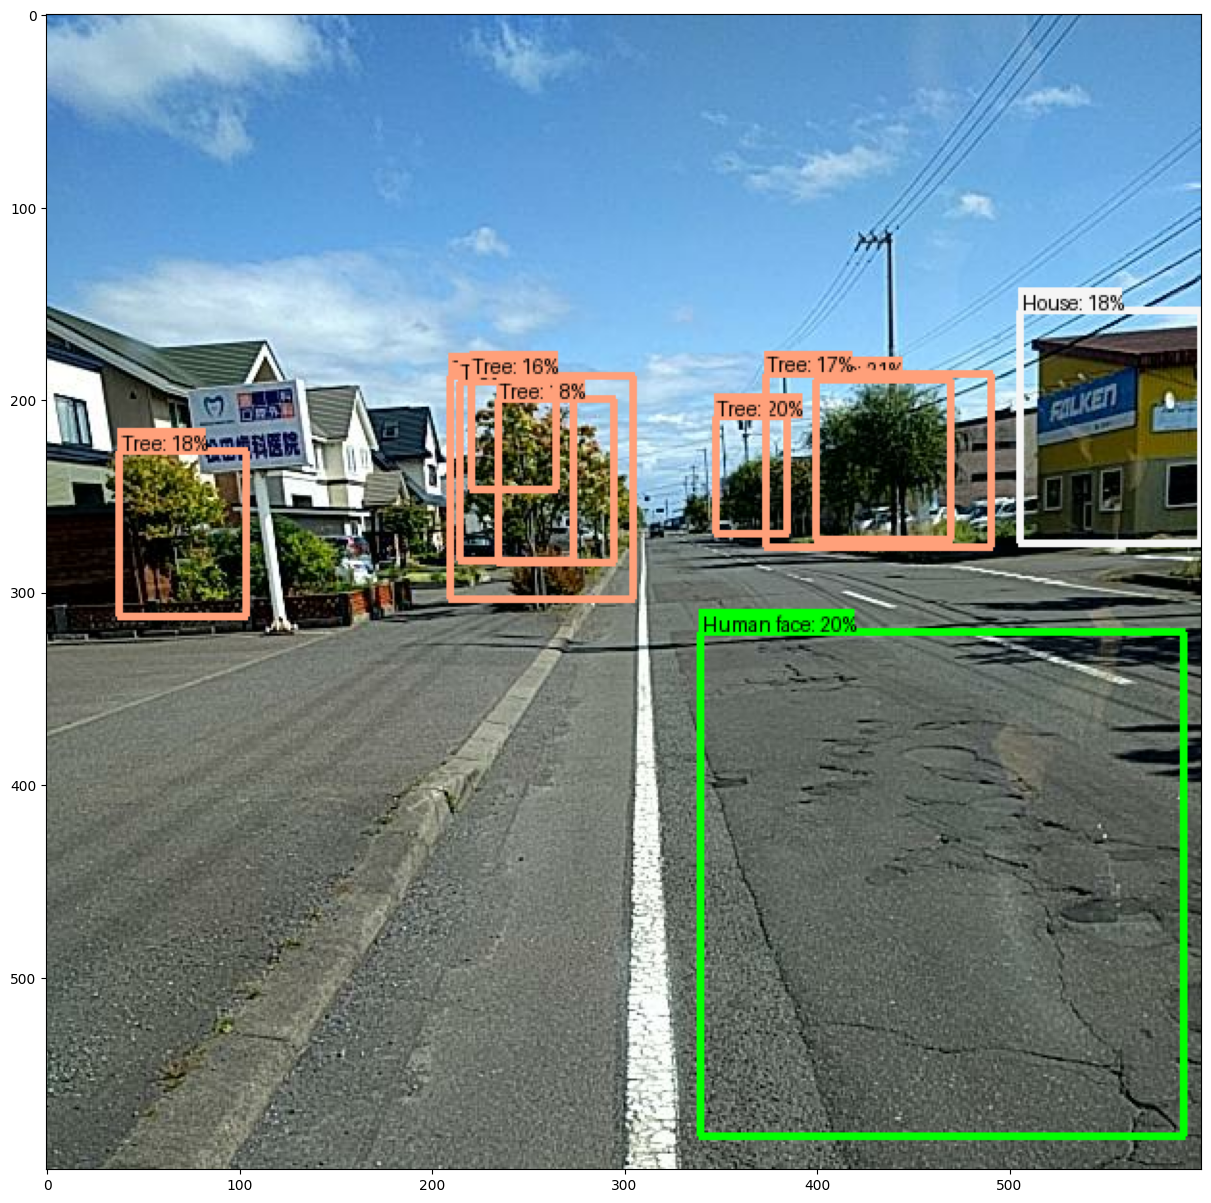

In [33]:
#tf.config.run_functions_eagerly(True)

sample_image = "../RDD2022/RDD2022_all_countries/Japan/Japan/train/images/Japan_000000.jpg"
run_detector(ssd_detector, sample_image)